# Sign Language Recognition System

Reduced notebook solving the 'Sign Language Recognition System' project of the [Udacity's Artificial Intelligence Nanodegree](https://www.udacity.com/course/artificial-intelligence-nanodegree--nd889). 

Source: https://github.com/udacity/AIND-Recognizer

The goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  The project The project comprises three parts: <br>
<ol>
<li>Create a variety of feature sets</li>
<li>Implement three different model selection criterion to determine the optimal number of hidden states for each word model</li>
<li>Implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.</li> 
</ol>


This project requires Python 3 and the following Python libraries installed:

[NumPy](http://www.numpy.org/), [SciPy](https://www.scipy.org/), [scikit-learn](http://scikit-learn.org/0.17/install.html), [pandas](http://pandas.pydata.org/), [matplotlib](http://matplotlib.org/), [jupyter](http://ipython.org/notebook.html), [hmmlearn](http://hmmlearn.readthedocs.io/en/latest/)


# Data and Features

## Load the initial database
A data handler designed for this database is provided as the `AslDb` class in the `asl_recognizer.asl_data` module.  This handler creates the initial pandas dataframe from the corpus of data included in the `asl_recognizer/data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  

In [40]:
import numpy as np
import pandas as pd
from asl_recognizer.asl_data import AslDb

asl = AslDb() # initializes the database
asl.df.head() # displays the first rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.loc[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.loc[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))
# print("Training sequences: {}".format(training.get_word_sequences('ALL')))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [42]:
training.get_word_Xlengths('CHICKEN')

(array([[-19,  38,  27,  89],
        [-19,  38,  23,  89],
        [-15,  39,  24,  92],
        [-12,  33,  24,  92],
        [-12,  33,  24,  92],
        [ -9,  32,  24,  92],
        [-10,  29,  21,  93],
        [-10,  29,  20,  94],
        [-10,  29,  20,  94],
        [-10,  29,  20,  94],
        [-10,  29,  20,  94],
        [-10,  29,  20,  98],
        [-10,  29,  20,  98],
        [ -8,  34,  20,  98],
        [ -8,  34,  13, 104],
        [-19,  35,  29,  75],
        [-19,  35,  29,  75],
        [-19,  35,  29,  75],
        [-19,  35,  25,  79],
        [-19,  35,  22,  80],
        [-14,  32,  21,  86],
        [-14,  32,  21,  86],
        [-14,  32,  14,  90],
        [-12,  32,  16,  90],
        [-12,  32,  16,  92],
        [-12,  32,  15,  94],
        [-12,  32,  15,  94],
        [-12,  32,  15,  94],
        [-12,  32,  15,  94],
        [-12,  32,  15,  97],
        [-10,  35,  15, 101],
        [ -6,  41,  11, 104]]), [15, 17])

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [8]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-ly,grnd-rx,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,157.036848,-19.567406,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,104.026144,-11.637255,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,118.505134,-13.452679,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [9]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-ly  grnd-rx  grnd-lx  left-x-mean  
video frame                                                   
98    0          113      119        9      -12   164.661438  
      1          113      119        9      -12   164.661438  
      2          113      119        9      -12   164.661438  
      3          113      119        9      -12   164.661438  
      4          113      119        9      -12   164.661438

##### Try it!

In [10]:
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()

<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [11]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd
asl.df['left-y-mean']= asl.df['speaker'].map(df_means['left-y'])
asl.df['right-x-mean']= asl.df['speaker'].map(df_means['right-x'])
asl.df['right-y-mean']= asl.df['speaker'].map(df_means['right-y'])

asl.df['left-x-std']= asl.df['speaker'].map(df_std['left-x'])
asl.df['left-y-std']= asl.df['speaker'].map(df_std['left-y'])
asl.df['right-x-std']= asl.df['speaker'].map(df_std['right-x'])
asl.df['right-y-std']= asl.df['speaker'].map(df_std['right-y'])

asl.df['norm-rx'] = (asl.df['right-x'] - asl.df['right-x-mean']) / asl.df['right-x-std']
asl.df['norm-ry'] = (asl.df['right-y'] - asl.df['right-y-mean']) / asl.df['right-y-std']
asl.df['norm-lx'] = (asl.df['left-x'] - asl.df['left-x-mean']) / asl.df['left-x-std']
asl.df['norm-ly'] = (asl.df['left-y'] - asl.df['left-y-mean']) / asl.df['left-y-std']

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']
#asl.df.head(100)

In [12]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle
asl.df['polar-rr'] = (asl.df['grnd-rx']**2 + asl.df['grnd-ry']**2)**0.5
asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'], asl.df['grnd-ry'])
asl.df['polar-lr'] = (asl.df['grnd-lx']**2 + asl.df['grnd-ly']**2)**0.5
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'], asl.df['grnd-ly'])

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [13]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'
asl.df['delta-rx'] = asl.df['right-x'].diff().fillna(method='bfill')
asl.df['delta-ry'] = asl.df['right-y'].diff().fillna(method='bfill')
asl.df['delta-lx'] = asl.df['left-x'].diff().fillna(method='bfill')
asl.df['delta-ly'] = asl.df['left-y'].diff().fillna(method='bfill')

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [14]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like

# delta2: features for left, right, x, y differences by TWO time steps
asl.df['delta2-rx'] = asl.df['right-x'].diff(periods=2).fillna(method='bfill')
asl.df['delta2-ry'] = asl.df['right-y'].diff(periods=2).fillna(method='bfill')
asl.df['delta2-lx'] = asl.df['left-x'].diff(periods=2).fillna(method='bfill')
asl.df['delta2-ly'] = asl.df['left-y'].diff(periods=2).fillna(method='bfill')

# TODO define a list named 'features_custom' for building the training set
features_custom = ['delta2-rx', 'delta2-ry', 'delta2-lx', 'delta2-ly']
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-ly  grnd-rx    ...        polar-lr  polar-ltheta  \
video frame                               ...                                 
98    0          113      119        9    ...      119.603512     -0.100501   
      1          113      119        9    ...      119.603512     -0.100501   
      2          113      119        9    ...      119.603512     -0.100501   
      3          113      119        9    ...      119.603512     -0.100501   
      4          113      119        9    ...      119.603512     -0.100501   

             delta-rx  delta-ry  delta-lx  delta-ly  delta2-rx  delta2-ry  \
video frame                                                                 
98    0           0.0       0.0       0.0       0.0        0.0        0.0   
      1           0.0       0.0       0.0       0.0        0.0        0.0   
      2           0.0       0.0       0.0       0.0        0.0        0.0   
      3           0.0       0.0       0.0       0.0        0.0        0.0   
      4           0.0       0.0       0.0       0.0        0.0        0.0   

             delta2-lx  delta2-ly  
video frame                        
98    0            0.0        0.0  
      1            0.0        0.0  
      2            0.0        0.0  
      3            0.0        0.0  
      4            0.0        0.0  

[5 rows x 35 columns]

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**
I finally chose delta difference by two time steps of cartesian coordinates (delta2) empirically after obtaining better results of the test recognizer with these custom features at the end of the project. In particular, delta2 resulted in better performance that other combinations of the above features, including my original choices: delta polar for several time steps differences.


<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [15]:
import warnings
import sklearn
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'CHICKEN'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for CHICKEN is 3
logL = -280.46497488078603


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [16]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for CHICKEN is 3
hidden state #0
mean =  [-10.52465357  31.76348636  16.90667251  95.62392688]
variance =  [  3.33069502   8.35276832   8.92722105  15.51814417]

hidden state #1
mean =  [-19.          35.85689931  26.28608853  80.28472341]
variance =  [  1.42873408e-03   1.83785024e+00   7.63372040e+00   3.39150218e+01]

hidden state #2
mean =  [-12.66061642  33.40688338  22.92794564  90.0557785 ]
variance =  [ 3.806808    6.73167313  2.07126266  8.09034177]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [17]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 4, features_custom) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 4
hidden state #0
mean =  [  8.25206209  -5.51168909  -4.6550317  -19.16012769]
variance =  [ 31.14594021   8.67822617  12.34836148  10.90097108]

hidden state #1
mean =  [-1.82783618 -0.09033934  0.79651681 -0.79917048]
variance =  [ 17.10078405   2.84042694   5.01366782   2.67672055]

hidden state #2
mean =  [ 1.18610861  7.27026212  0.99679608  5.87654915]
variance =  [ 27.34984439  25.92752256   9.76958653  19.16099588]

hidden state #3
mean =  [  1.62296834   2.69820172   0.67267809 -14.31699432]
variance =  [  3.388973     5.50774406  12.21018603  48.84871828]

logL = -513.5663011915328


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [18]:
%matplotlib inline

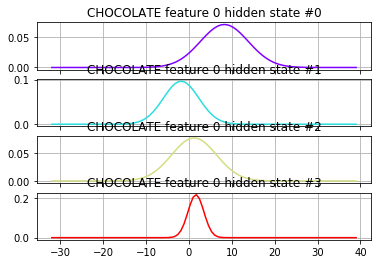

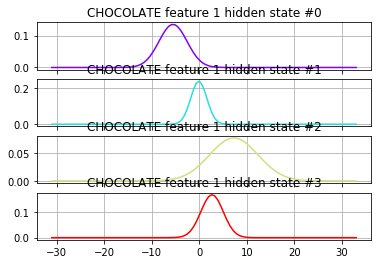

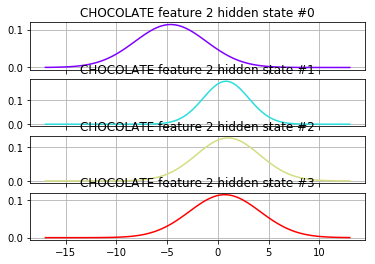

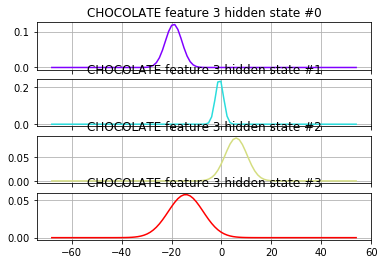

In [19]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `SelectorModel` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [20]:
import math
import statistics
import warnings

import numpy as np
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import KFold
from asl_recognizer.asl_utils import combine_sequences


class ModelSelector(object):
    '''
    base class for model selection (strategy design pattern)
    '''

    def __init__(self, all_word_sequences: dict, all_word_Xlengths: dict, this_word: str,
                 n_constant=3,
                 min_n_components=2, max_n_components=10,
                 random_state=14, verbose=False):
        self.words = all_word_sequences
        self.hwords = all_word_Xlengths
        self.sequences = all_word_sequences[this_word]
        self.X, self.lengths = all_word_Xlengths[this_word]
        self.this_word = this_word
        self.n_constant = n_constant
        self.min_n_components = min_n_components
        self.max_n_components = max_n_components
        self.random_state = random_state
        self.verbose = verbose

    def select(self):
        raise NotImplementedError

    def base_model(self, num_states):
        # with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=DeprecationWarning)
        # warnings.filterwarnings("ignore", category=RuntimeWarning)
        try:
            hmm_model = GaussianHMM(n_components=num_states, covariance_type="diag", n_iter=1000,
                                    random_state=self.random_state, verbose=False).fit(self.X, self.lengths)
            if self.verbose:
                print("model created for {} with {} states".format(self.this_word, num_states))
            return hmm_model
        except:
            if self.verbose:
                print("failure on {} with {} states".format(self.this_word, num_states))
            return None


class SelectorConstant(ModelSelector):
    """ select the model with value self.n_constant

    """
    def select(self):
        """ select based on n_constant value

        :return: GaussianHMM object
        """
        best_num_components = self.n_constant
        return self.base_model(best_num_components)


class SelectorBIC(ModelSelector):
    """ select the model with the lowest Baysian Information Criterion(BIC) score

    http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf
    Bayesian information criteria: BIC = -2 * logL + p * logN
    """

    def select(self):
        """ select the best model for self.this_word based on
        BIC score for n between self.min_n_components and self.max_n_components
        :return: GaussianHMM object
        """
        warnings.filterwarnings("ignore", category=DeprecationWarning)

        # TODO implement model selection based on BIC scores

        best_BIC = float('inf')     # hold the lowest BIC found
        best_model = None           # hold the model with the lowest BIC found

        # main loop: get model and score for different number of hidden states and update best_BIC and best_model
        for n_components in range(self.min_n_components, self.max_n_components+1):
            logL = None
            model = self.base_model(n_components) # avoid code duplication using the inherited method
            if model is None:   # failed
                continue
            try:  # hmmlearn stability issues
                logL = model.score(self.X, self.lengths)
            except:
                continue

            # BIC = -2 log L + p log N  (the lower the better)
            # p = num free params = transistion probs(n*n) + means(n*f) + covars(n*f)  (feedback from project review)
            p = n_components**2 + (2 * len(self.X[0]) * n_components)
            BIC = -2 * logL + p * np.log(len(self.X))
            if  BIC < best_BIC:
                best_BIC = BIC
                best_model = model

        return best_model


class SelectorDIC(ModelSelector):
    """ select best model based on Discriminative Information Criterion

    Biem, Alain. "A model selection criterion for classification: Application to hmm topology optimization."
    Document Analysis and Recognition, 2003. Proceedings. Seventh International Conference on. IEEE, 2003.
    http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf
    DIC = log(P(X(i)) - 1/(M-1)SUM(log(P(X(all but i))
    """

    def select(self):
        warnings.filterwarnings("ignore", category=DeprecationWarning)

        # TODO implement model selection based on DIC scores

        best_DIC = float('-inf')    # hold the highest BIC found
        best_model = None           # hold the model with the highest BIC found
        my_word = self.this_word    # word to evaluate

        # main loop: get model and score for different number of hidden states and update best_DIC and best_model
        for n_components in range(self.min_n_components, self.max_n_components+1):
            logL = None     # likelihood of the trained model
            anti_logL = []  # list containing all the anti likelihoods of the trained model
            self.this_word = my_word

            # train the model for current word (self.this_word)
            model = self.base_model(n_components)  # avoid code duplication using the inherited method
            if model is None:   # failed
                continue
            # get the likelihood of the model
            try:  # hmmlearn stability issues
                logL = model.score(self.X, self.lengths)
            except:
                continue

            # get the anti-likehoods (score every other word for the current model)
            for other_word in self.hwords:
                if other_word == my_word:
                    continue
                X, lengths = self.hwords[other_word]
                try:  # stability issues for hmmlearn v<0.2.1
                    anti_logL.append(model.score(X, lengths))
                except:
                    continue

            # I found the docstring formula a bit confusing   DIC = log(P(X(i)) - 1/(M-1)SUM(log(P(X(all but i)) :
            # The size of anti_logL is already M-1, as the word evaluated is not included in anti_logL.
            # Biem, Alain: "DIC = Difference between the likelihood of the data an the the average of anti-likelihood"
            # From the paper we can state: DIC = log(P(X(i)) - average(log(P(X(all but i))
            DIC = logL - np.average(anti_logL)  # The higher the better
            if  DIC > best_DIC:
                best_DIC = DIC
                best_model = model

        return best_model


class SelectorCV(ModelSelector):
    """ select best model based on average log Likelihood of cross-validation folds """

    def select(self):
        """ :return: GaussianHMM object """

        warnings.filterwarnings("ignore", category=DeprecationWarning)
        # TODO implement model selection using CV

        # KFold default n_splits = 3 is used here. Sequences of size lower than 3 must be considered:
        if len(self.sequences) >= 3:
            n_splits = 3
        elif len(self.sequences) == 2:
            n_splits = 2
        else:
            # print("No Cross Validation is possible for word: ", self.this_word, "only has 1 occurrence")
            return None

        best_score = float('-inf')  # hold the highest average of cross-validation scores found
        best_model = None           # hold the model with the highest average of cross-validation score found

        # main loop: get model and score for different number of hidden states and update best_score and best_model
        for n_components in range(self.min_n_components, self.max_n_components+1):

            split_method = KFold(n_splits=n_splits)
            logL = []  # list of cross validation scores obtained

            # get the model for the combined cross-validation training sequences and score with their combined
            #  validation sequences filling the list 'logL'
            for cv_train_idx, cv_test_idx in split_method.split(self.sequences):

                self.X, self.lengths = combine_sequences(cv_train_idx, self.sequences)
                model = self.base_model(n_components)  # avoid code duplication using the inherited method
                if model is None:   # failed
                    continue

                test_X, test_lengths = combine_sequences(cv_test_idx, self.sequences)
                try:   # hmmlearn stability issues
                    logL.append(model.score(test_X, test_lengths))
                except:
                    continue

            if model is None or logL == []:
                continue

            score = np.mean(logL)  # The higher the better
            if  score > best_score:
                best_score = score
                best_model = model

        return best_model

In [21]:
training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'CHICKEN' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for CHICKEN is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [22]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [23]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [24]:
# TODO: Implement SelectorCV in my_model_selector.py

# from importlib import reload
# import my_model_selectors
# reload(my_model_selectors)

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 11 states with time 0.36226025100040715 seconds
Training complete for BOOK with 6 states with time 4.670327365000048 seconds
Training complete for VEGETABLE with 2 states with time 2.111918381999203 seconds
Training complete for FUTURE with 2 states with time 4.28351991999989 seconds
Training complete for JOHN with 12 states with time 43.24632055499933 seconds


In [26]:
training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.3677169889997458 seconds
Training complete for BOOK with 8 states with time 2.5329106350000075 seconds
Training complete for VEGETABLE with 9 states with time 0.8644760449988098 seconds
Training complete for FUTURE with 9 states with time 2.617932397999539 seconds
Training complete for JOHN with 13 states with time 24.188574800000424 seconds


In [27]:
# TODO: Implement SelectorDIC in module my_model_selectors.py

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.9306247669992445 seconds
Training complete for BOOK with 15 states with time 4.730142512000384 seconds
Training complete for VEGETABLE with 15 states with time 4.15975666399936 seconds
Training complete for FUTURE with 15 states with time 5.039948007999556 seconds
Training complete for JOHN with 15 states with time 25.560548058001586 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

**CV**:  Common in supervised learning to avoid partitioning the training set for validation. Among the tree model selectors, CV is the only one (cross)validated with sequences different of the training sets. However the running time needed is higher than direct selectors like BIC, since for each word several models must be created for cross-validation (combinations of training-validation sequences).  

**BIC**: Simple selector that penalizes the resulted likelihood with the complexity of the model (more hidden layers increases the risk of overfitting). It needs less running time than CV and DIC, as only one model and one score must be computed per number of hidden nodes. 

**DIC**: The penalty term in DIC is based on the average likelihood for the other words. That is why it has the highest computational cost of the three: a score for each word of the training set must be computed for each number of hidden states.

Further comparisons will be discussed together with the results of the part 3 of the project.


<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [29]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [30]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [33]:
import warnings
from asl_recognizer.asl_data import SinglesData


def recognize(models: dict, test_set: SinglesData):
    """ Recognize test word sequences from word models set

   :param models: dict of trained models
       {'SOMEWORD': GaussianHMM model object, 'SOMEOTHERWORD': GaussianHMM model object, ...}
   :param test_set: SinglesData object
   :return: (list, list)  as probabilities, guesses
       both lists are ordered by the test set word_id
       probabilities is a list of dictionaries where each key a word and value is Log Liklehood
           [{SOMEWORD': LogLvalue, 'SOMEOTHERWORD' LogLvalue, ... },
            {SOMEWORD': LogLvalue, 'SOMEOTHERWORD' LogLvalue, ... },
            ]
       guesses is a list of the best guess words ordered by the test set word_id
           ['WORDGUESS0', 'WORDGUESS1', 'WORDGUESS2',...]
   """
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    probabilities = []
    guesses = []
    # TODO implement the recognizer

    test_sequences = list(test_set.get_all_Xlengths().values()) # extract X and Xlength lists in a variable

    # Main loop: iterate for each word sequence and fill the lists probabilities and guesses
    for test_X, test_Xlength in  test_sequences:

        best_score = float('-inf')  # hold the highest likelihood found for the current sequence
        best_word = None            # hold the word with the highest likelihood found for the current sequence
        prob_dict = {}              # dictionary to fill before being added to the probabilities list {word: LogL}

        # Score the models avaliable for different words for the current sequence, fill prob_dict and update best_score
        # and best_word found
        for word, model in models.items():
            try:  # hmmlearn stability issues
                logL = model.score(test_X, test_Xlength)
            except:
                logL = None

            prob_dict[word] = logL
            if logL is not None:
                if logL > best_score:
                    best_score = logL
                    best_word = word

        probabilities.append(prob_dict)
        guesses.append(best_word)

    return probabilities, guesses


# if __name__ == "__main__":
#     from  asl_test_recognizer import TestRecognize
#     test_model = TestRecognize()
#     test_model.setUp()
#     test_model.test_recognize_probabilities_interface()

In [34]:
from asl_recognizer.asl_utils import show_errors

In [35]:
%%time
#  BASE COMBINATION:  SelectorConstant with features_ground.  WER = 0.669

# TODO Choose a feature set and model selector
features = features_ground # change as needed
model_selector = SelectorConstant # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6685393258426966
Total correct: 59 out of 178
Video  Recognized                                                    Correct
    2: *GO WRITE *ARRIVE                                             JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *GO1 *IX CAN                                   JOHN CAN GO CAN
   12: JOHN *HAVE *WHAT CAN                                          JOHN CAN GO CAN
   21: JOHN *HOMEWORK *NEW *PREFER *CAR *CAR *FUTURE *EAT            JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *FRANK *TELL *LOVE *TELL *LOVE                                JOHN LIKE IX IX IX
   28: *FRANK *TELL *LOVE *TELL *LOVE                                JOHN LIKE IX IX IX
   30: *SHOULD LIKE *GO *GO *GO                                      JOHN LIKE IX IX IX
   36: *VISIT VEGETABLE *YESTERDAY *GIVE *MARY *MARY                 MARY VEGETABLE KNOW IX LIKE CORN1
   40: *SUE *GIVE *CORN *VEGETABLE *GO                               JOHN IX THINK MARY LOVE
   43: *FRANK *GO BUY HOUSE         

In [36]:
%%time
#  COMBINATION 1:   SelectorCV with features_polar.  WER = 0.607

# TODO Choose a feature set and model selector
features = features_polar # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6067415730337079
Total correct: 70 out of 178
Video  Recognized                                                    Correct
    2: *POSS *BROTHER *NEW                                           JOHN WRITE HOMEWORK
    7: JOHN *HAVE GO *WHAT                                           JOHN CAN GO CAN
   12: *IX *WHAT *WHAT CAN                                           JOHN CAN GO CAN
   21: JOHN *NEW *POSS *JOHN *CAR *CAR *VISIT *FUTURE                JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE *LOVE *JOHN IX                                      JOHN LIKE IX IX IX
   28: JOHN *JOHN *MARY *JOHN IX                                     JOHN LIKE IX IX IX
   30: JOHN LIKE IX *LIKE IX                                         JOHN LIKE IX IX IX
   36: MARY VEGETABLE *GIRL *GIVE *MARY *MARY                        MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GIVE *CORN *JOHN *IX                                    JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE           

In [37]:
%%time
#  COMBINATION 2:  SelectorBIC with features_polar.  WER = 0.545

# TODO Choose a feature set and model selector
features = features_polar # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5449438202247191
Total correct: 81 out of 178
Video  Recognized                                                    Correct
    2: *GO WRITE *NEW                                                JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE GO *ARRIVE                                       JOHN CAN GO CAN
   12: JOHN *WHAT *GO1 CAN                                           JOHN CAN GO CAN
   21: JOHN *NEW WONT *NOT *GIVE1 *TEACHER *FUTURE *WHO              JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE *LOVE *WHO IX                                       JOHN LIKE IX IX IX
   28: JOHN *WHO *FUTURE *WHO IX                                     JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *VISIT VEGETABLE *GIRL *GIVE *MARY *MARY                      MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *VISIT *FUTURE1 *JOHN *MARY                              JOHN IX THINK MARY LOVE
   43: JOHN *FUTURE BUY HOUSE       

In [38]:
%%time
#  COMBINATION 3:  SelectorCV with features_custom(delta2).  WER = 0.539

# TODO Choose a feature set and model selector
features = features_custom # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5393258426966292
Total correct: 82 out of 178
Video  Recognized                                                    Correct
    2: JOHN *IX *ARRIVE                                              JOHN WRITE HOMEWORK
    7: JOHN *HAVE GO *TEACHER                                        JOHN CAN GO CAN
   12: JOHN CAN *FUTURE CAN                                          JOHN CAN GO CAN
   21: JOHN *NOT *GIVE1 *JOHN *NEW *VISIT *MARY *MARY                JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *MARY IX IX IX                                           JOHN LIKE IX IX IX
   28: JOHN *IX IX IX IX                                             JOHN LIKE IX IX IX
   30: JOHN *IX IX IX IX                                             JOHN LIKE IX IX IX
   36: *JOHN *MARY *IX *LIKE *MARY *JOHN                             MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN IX *JOHN *JOHN *JOHN                                     JOHN IX THINK MARY LOVE
   43: JOHN *MARY *GO HOUSE         

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

A - SelectorCV + features_polar. WER = 0.607  (wall time: 112s)

B - SelectorBIC + features_polar. WER = 0.545  (wall time: 71s)

C - SelectorCV  + features_custom(delta2). WER = 0.539  (wall time: 118s)

The best combination, SelectorCV + features_custom(delta2), is mainly due to an acurrate choice for the custom features "delta2":
- With normalized features, the recognizer always performed worse than with the other features analyzed. 
- With polar features, less than 60% could be achieved with DIC and BIC only (54.4%). 
- With delta features, however, the recognizer never produced a word error rate lower than 60%, being the best result, 61.2%, obtained with selectorCV. 
- After using the custom "delta2" features it was easy to get error rates lower than 60% for the three model selectors, allowing a better comparison of the them, where SelectorCV had a better performance than BIC and DIC (opposite to using polar features)

Attending the running time, BIC model selector is the fastest for all tests for the reasons discussed in part 2 followed by Cross-Validation (~1.5 times longer), and finally DIC (~3 times longer). DIC was discarded after the first combinations since similar or better performances were usually reached with cross-validation and BIC, also needing less running time.

Finally, to improve our WER we could modify "delta2" or "polar" including terms from other features or combinations of features (linear function, etc.). Other variables like zoom and hand orientations, unavailable in this project, could help to elaborate more accurate features.

A better option is to include statistical data (as suggested in the lesson and also proposed in the optional exercise) with information about the occurrence of a word in a sentence, or the probability of the word to appears next to other words (biased priors could be created before training). By using semantics rules, for example, a heuristic strategy based on previous sequences could restrict the search to meaningful words only. 

Moreover, as we are using ordered sequences, we could implement a recurrent neural network (LSTM) to improve our WER.

